In [1]:
# import libraries
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from pathlib import Path
import os

from shutil import make_archive

# ignore warnings
import warnings
warnings.filterwarnings("ignore")

In [2]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [3]:
powers_of_two = np.array([[4], [2], [1]])  # shape (3, 1)

def step(x, rule_binary):
    """Makes one step in the cellular automaton.

    Args:
        x (np.array): current state of the automaton
        rule_binary (np.array): the update rule

    Returns:
        np.array: updated state of the automaton
    """
    x_shift_right = np.roll(x, 1)  # circular shift to right
    x_shift_left = np.roll(x, -1)  # circular shift to left
    y = np.vstack((x_shift_right, x, x_shift_left)).astype(np.int8)  # stack row-wise, shape (3, cols)
    z = np.sum(powers_of_two * y, axis=0).astype(np.int8)  # LCR pattern as number

    return rule_binary[7 - z]

In [4]:
def cellular_automaton(rule_number, size, steps,
                       init_cond='random', impulse_pos='center'):
    """Generate the state of an elementary cellular automaton after a pre-determined
    number of steps starting from some random state.

    Args:
        rule_number (int): the number of the update rule to use
        size (int): number of cells in the row
        steps (int): number of steps to evolve the automaton
        init_cond (str): either `random` or `impulse`. If `random` every cell
        in the row is activated with prob. 0.5. If `impulse` only one cell
        is activated.
        impulse_pos (str): if `init_cond` is `impulse`, activate the
        left-most, central or right-most cell.

    Returns:
        np.array: final state of the automaton
    """
    assert 0 <= rule_number <= 255
    assert init_cond in ['random', 'impulse']
    assert impulse_pos in ['left', 'center', 'right']

    rule_binary_str = np.binary_repr(rule_number, width=8)
    rule_binary = np.array([int(ch) for ch in rule_binary_str], dtype=np.int8)
    x = np.zeros((steps, size), dtype=np.int8)

    if init_cond == 'random':  # random init of the first step
        x[0, :] = np.array(np.random.rand(size) < 0.5, dtype=np.int8)

    if init_cond == 'impulse':  # starting with an initial impulse
        if impulse_pos == 'left':
            x[0, 0] = 1
        elif impulse_pos == 'right':
            x[0, size - 1] = 1
        else:
            x[0, size // 2] = 1

    for i in range(steps - 1):
        x[i + 1, :] = step(x[i, :], rule_binary)

    return x

In [5]:
def generateSamples(cells, steps, rules, t=10, path='./samples/rule_'):
    '''
    0 <= rule_number <= 255
    i_cond in ['random', 'impulse']
    impulse_pos in ['left', 'center', 'right']
    impulse = ['left', 'center', 'right']
    Args:
        - cells (int): number of cells in a row
        - steps (int): number of steps to evolve
        - rules (list): list of rule numbers to use for image generation
        - t (int): desired images per rule
        - path (str): desired path to save images
    '''

    # if i_cond == 'random':
    for rule in rules:
        for ix in range(t):
            img = cellular_automaton(rule, cells, steps, 'random', 'center')
            # tile generated automata image
            M = img.shape[0]//16
            N = img.shape[1]//16
            tiles = [img[x:x+M,y:y+N] for x in range(0,img.shape[0],M) for y in range(0,img.shape[1],N)]

            for i, tile in enumerate(tiles):
                dir = path + 'rule_{}/'.format(rule)
                Path(dir).mkdir(parents=True, exist_ok=True)
                num = "_" + str(ix).zfill(3) + '_' + str(i).zfill(4)
                imgName = dir + "{}".format(rule) + num
                # check if image exists, bc class balancing
                plt.imsave(imgName + '_' + str(np.random.randint(10000)) + '.png', tile)
            print('processed rule', str(rule), end='\r')
    # else:

    #     for rule in range(255):
    #         for imp in impulse:
    #             x = cellular_automaton(rule, size, steps, i_cond, imp)
    #             Path(path + 'rule_{}'.format(rule)).mkdir(parents=True, exist_ok=True)
    #             plt.imsave(path +'rule_{}/{}_{}.png'.format(rule, rule, imp), x)

In [6]:
def balance_dataset(c1, c2):
    '''
    balance len(c1) to match len(c2)
    '''
    c1_cpy = c1

    x = len(c2) // len(c1)
    c1_cpy = c1_cpy * x
    return c1_cpy

In [7]:
class1 = [0, 8, 32, 40, 128, 136, 160, 168]
class2 = [1, 2, 3, 4, 5, 6, 7, 9, 10, 11, 12, 13, 14, 15, 19,
          23, 24, 25, 26, 27, 28, 29, 33, 34, 35, 36, 37, 38,
          42, 43, 44, 46, 50, 51, 56, 57, 58, 62, 72, 73, 74,
          76, 77, 78, 94, 104, 108, 130, 132, 134, 138, 140,
          142, 152, 154, 156, 162, 164, 170, 172, 178, 184,
          200, 204, 232]
class3 = [18, 22, 30, 45, 60, 90, 105, 122, 126, 146, 150]
class4 = [41, 54, 106, 110]

class1_equiv = [0, 255,
                8, 64, 239, 253,
                32, 251,
                40, 96, 235, 249,
                128, 254,
                136, 192, 238, 252,
                160, 250,
                168, 224, 234, 248]

class2_equiv = [1, 127,
                2, 16, 191, 247,
                3, 17, 63, 119,
                4, 223,
                5, 95,
                6, 20, 159, 215,
                7, 21, 31, 87,
                9, 65, 111, 125,
                10, 80, 175, 245,
                11, 47, 81, 117,
                12, 68, 207, 221,
                13, 69, 79, 93,
                14, 84, 143, 213,
                15, 85,
                19, 55,
                23,
                24, 66, 189, 231,
                25, 61, 67, 103,
                26, 82, 167, 181,
                27, 39, 53, 83,
                28, 70, 157, 199,
                29, 71,
                33, 123,
                34, 48, 187, 243,
                35, 49, 59, 115,
                36, 219,
                37, 91,
                38, 52, 155, 211,
                42, 112, 171, 241,
                43, 113,
                44, 100, 203, 217,
                46, 116, 139, 209,
                50, 179,
                51,
                56, 98, 185, 227,
                57, 99,
                58, 114, 163, 177,
                62, 118, 131, 145,
                72, 237,
                73, 109,
                74, 88, 173, 229,
                76, 205,
                77,
                78, 92, 141, 197,
                94, 133,
                104, 233,
                108, 201,
                130, 144, 190, 246,
                132, 222,
                134, 148, 158, 214,
                138, 174, 208, 244,
                140, 196, 206, 220,
                142, 212,
                152, 188, 194, 230,
                154, 166, 180, 210,
                156, 198,
                162, 176, 186, 242,
                164, 218,
                170, 240,
                172, 202, 216, 228,
                178,
                184, 226,
                200, 236,
                204,
                232]
class3_equiv = [18, 183,
                22, 151,
                30, 86, 135, 149,
                45, 75, 89, 101,
                60, 102, 153, 195,
                90, 165,
                105,
                122, 161,
                126, 129,
                146, 182,
                150]
class4_equiv = [41, 97, 107, 121,
                54, 147,
                106, 120, 169, 225,
                110, 124, 137, 193]


In [8]:
c_rest = class1 + class2 + class3
c4 = balance_dataset(class4, c_rest)

c_rest_equiv = class1_equiv + class2_equiv + class3_equiv
c4_equiv = balance_dataset(class4_equiv, c_rest_equiv)

In [9]:
print(len(c_rest), len(c4))
print(len(c_rest_equiv), len(c4_equiv))

84 84
242 238


In [ ]:
# dataset size balancing
# c1 = balance_dataset(class1, class2)
# c3 = balance_dataset(class3, class2)
# c4 = balance_dataset(class4, class2)

# c1_eq = balance_dataset(class1_equiv, class2_equiv)
# c3_eq = balance_dataset(class3_equiv, class2_equiv)
# c4_eq = balance_dataset(class4_equiv, class2_equiv)

# print(len(c1), len(class2), len(c3), len(c4))
# print(len(c1_eq), len(class2_equiv), len(c3_eq), len(c4_eq))

64 65 55 64
192 192 182 182


In [10]:
t = 1
evolution_cells = 512
evolution_steps = 512

In [11]:
p1 = f'./test_samples{t}_{evolution_steps}'+'_4VR'
p2 = f'./test_samples{t}_{evolution_steps}'+'_4VR'+'_equiv'

In [12]:
# for c in [c1, class2, c3, c4]:
for c in [c_rest, c4]:
    generateSamples(evolution_cells, evolution_steps, c, t=t, path=p1+'/')

In [13]:
# for c in [c1_eq, class2_equiv, c3_eq, c4_eq]:
for c in[c_rest_equiv, c4_equiv]:
    generateSamples(evolution_cells, evolution_steps, c, t=t, path=p2+'/')

In [14]:
make_archive(p1, "zip", p1)
make_archive(p2, "zip", p2)

'/content/test_samples1_512_4VR_equiv.zip'

In [15]:
!echo $p1
!echo $p2

./test_samples1_512_4VR
./test_samples1_512_4VR_equiv


In [16]:
%env name1=$p1
%env name2=$p2

env: name1=./test_samples1_512_4VR
env: name2=./test_samples1_512_4VR_equiv


In [17]:
!cp $name1.zip ./drive/Shareddrives/Memoria/samples/$name1.zip
!cp $name2.zip ./drive/Shareddrives/Memoria/samples/$name2.zip

In [ ]:
#!rm -rf samples*
# !mv ./drive/Shareddrives/Memoria/samples/samples5000_32.zip ./drive/Shareddrives/Memoria/samples/samples10000_512.zip

In [ ]:
x = cellular_automaton(110, 512, 512)

In [ ]:
x.shape

(512, 512)

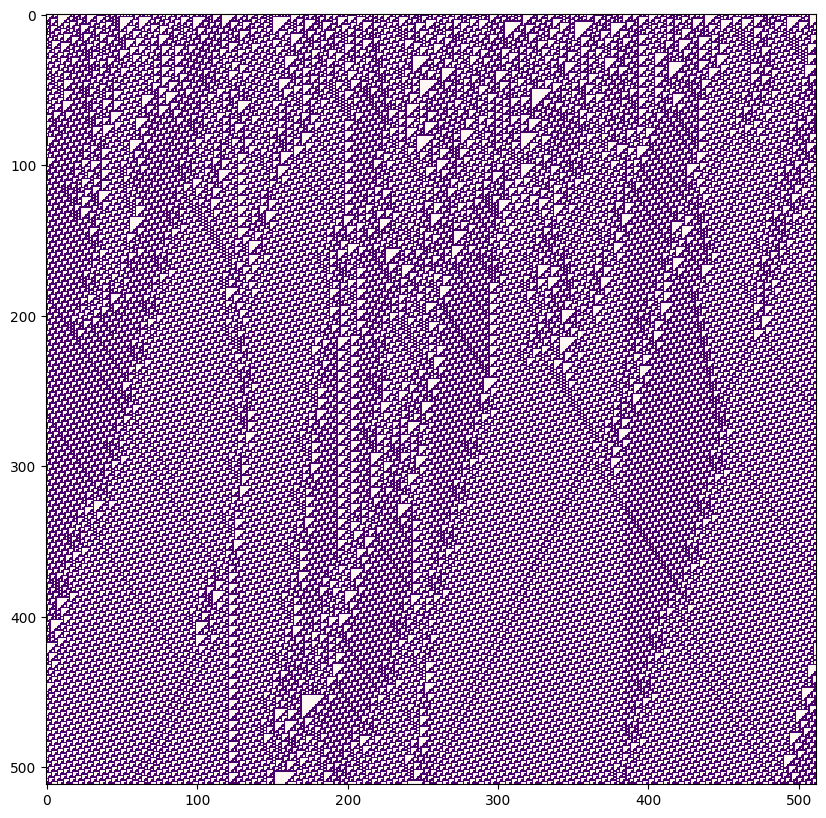

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(x, interpolation='none',cmap='RdPu')
ax.xaxis.set_label_position('top')
plt.show()

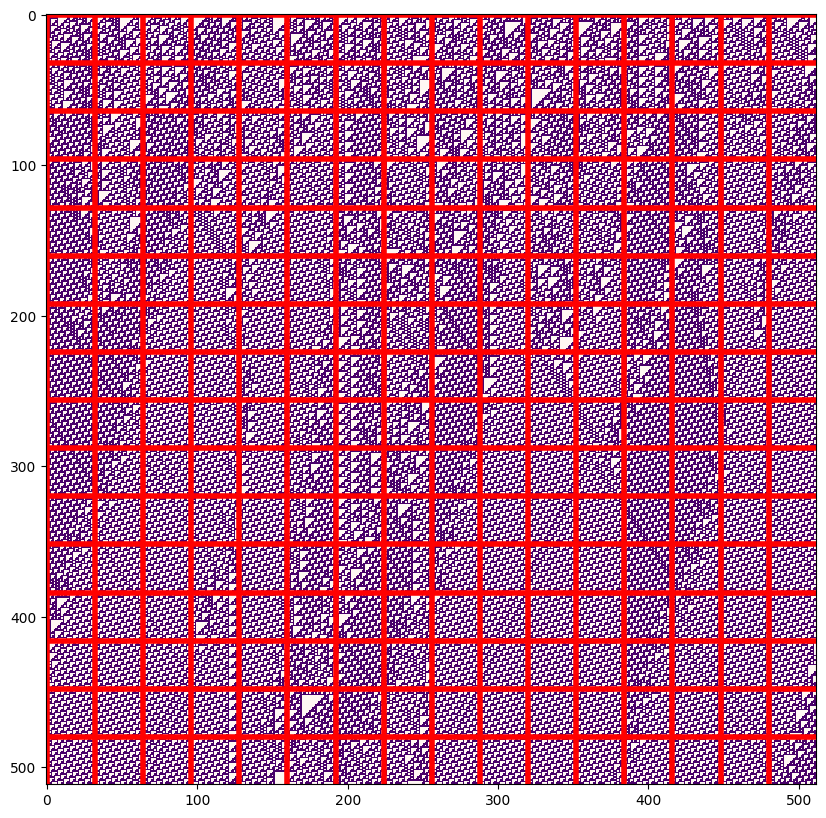

In [ ]:
plt.figure(figsize=(10, 10))
plt.imshow(x, interpolation='none',cmap='RdPu')

for i in range(0, 512, 32):
    plt.axline((i, 0), (i, 511), linewidth=4, color='r')
    plt.axline((0, i), (511, i), linewidth=4, color='r')

plt.show()